# Solar power plant: How it works?
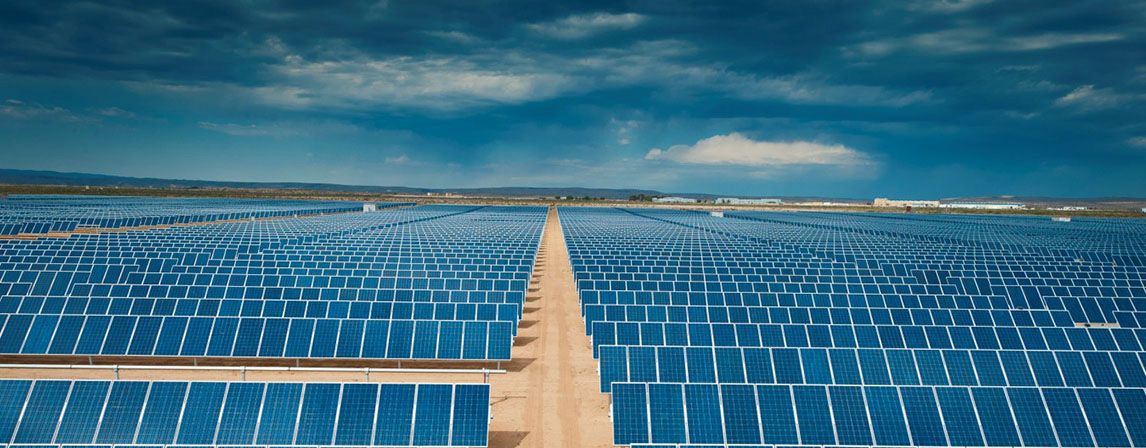

#### Long story short: when a photon hits the surface of the photovoltaic cell, its energy is transferred to the electrons present on the silicon cell. These electrons are "excited" and begin to flow in the circuit producing electric current. A solar panel produces Direct Current energy,(DC power).
#### Then, it's up to the inverter to convert it into alternating current to transport it and use it in our distribution networks. In fact, domestic and industrial buildings are designed for the transport and use of alternating current.

#### Every solar power plant consists at least of two basic components:
1. Modules- that convert sunlight into electricity
2. One or more inverters- devices that convert direct current into alternating current. 

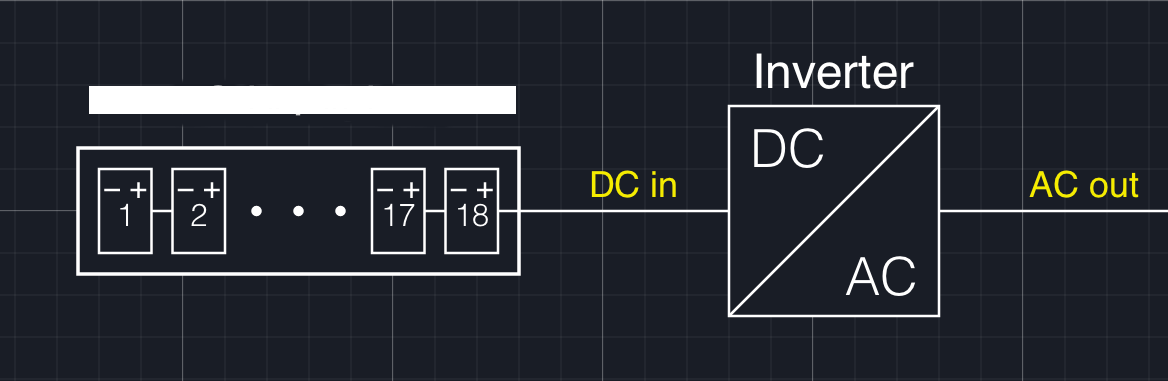

#### Typically the factors that determine the performance of a solar power plant are:
* Temperature
* Dirtiness
* Inverters Efficiency
* Inverters or panels seniority

# So where are the challenges?

In this paper we will answer two main question:

1. Can we identify faulty or suboptimally performing equipment?
2. Can we predict the power generation for next couple of days? - this allows for better grid management

## Before going into deep with our tasks, a quick EDA on PLANT_1:
**Notice that we're going to work only on one plant, to simplify at best our work.**

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import warnings
import datetime as dt
import matplotlib.dates as mdates
warnings.filterwarnings('ignore')

In [13]:
gen_1=pd.read_csv('Plant_1_Generation_Data.csv')
gen_1.drop('PLANT_ID',1,inplace=True)
sens_1= pd.read_csv('Plant_1_Weather_Sensor_Data.csv')
sens_1.drop('PLANT_ID',1,inplace=True)
#format datetime
gen_1['DATE_TIME']= pd.to_datetime(gen_1['DATE_TIME'],format='%d-%m-%Y %H:%M')
sens_1['DATE_TIME']= pd.to_datetime(sens_1['DATE_TIME'],format='%Y-%m-%d %H:%M:%S')

# Daily Yield & AC-DC power

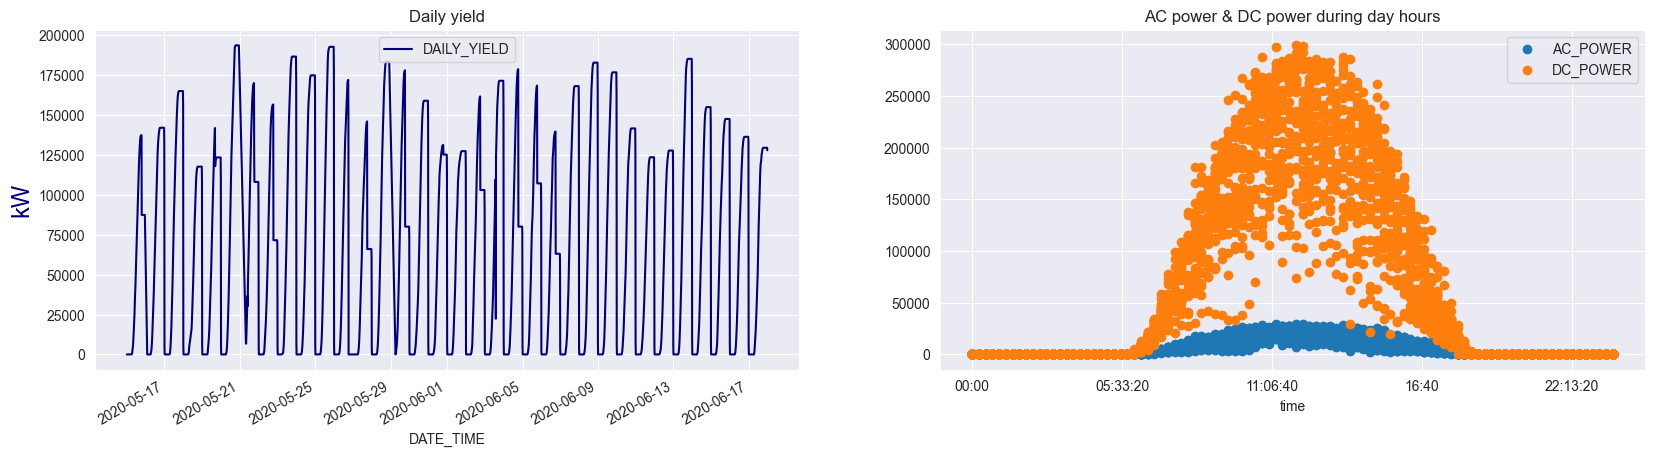

In [34]:
df_gen=gen_1.groupby('DATE_TIME').sum().reset_index()
df_gen['time']=df_gen['DATE_TIME'].dt.time

fig,ax = plt.subplots(ncols=2,nrows=1,dpi=100,figsize=(20,5))
# daily yield plot
df_gen.plot(x='DATE_TIME',y='DAILY_YIELD',color='navy',ax=ax[0])
# AC & DC power plot
df_gen.set_index('time').drop('DATE_TIME',1)[['AC_POWER','DC_POWER']].plot(style='o',ax=ax[1])

ax[0].set_title('Daily yield',)
ax[1].set_title('AC power & DC power during day hours')
ax[0].set_ylabel('kW',color='navy',fontsize=17)
plt.show()

# Daily and Total Yield

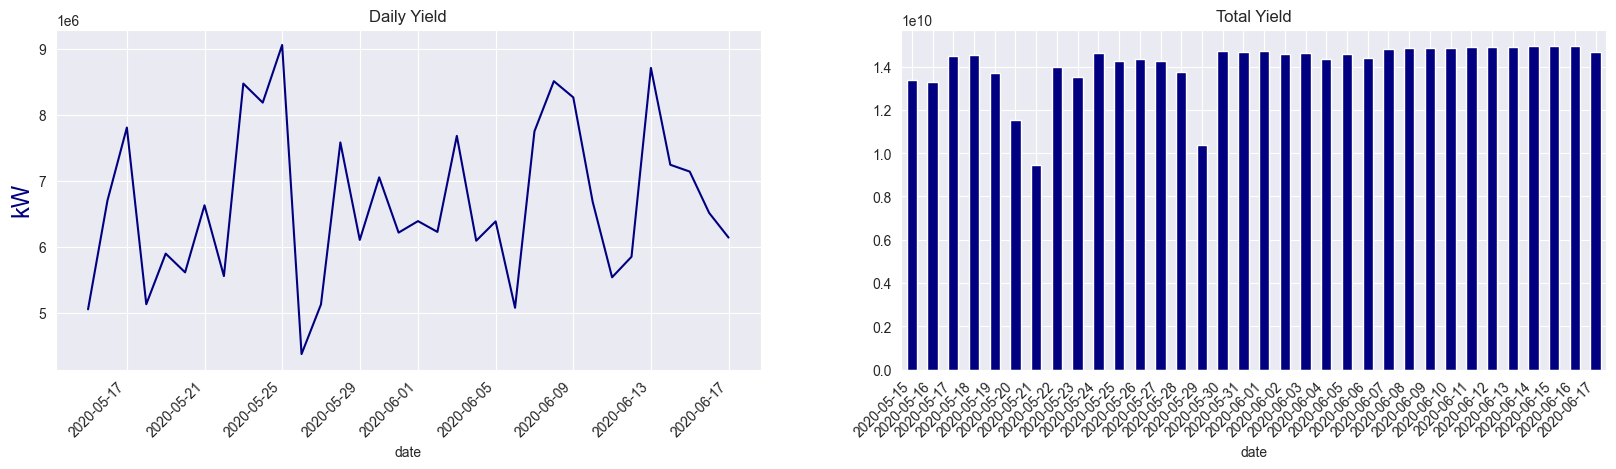

In [15]:
daily_gen=df_gen.copy()
daily_gen['date']=daily_gen['DATE_TIME'].dt.date

daily_gen=daily_gen.groupby('date').sum()

fig,ax= plt.subplots(ncols=2,dpi=100,figsize=(20,5))
daily_gen['DAILY_YIELD'].plot(ax=ax[0],color='navy')
daily_gen['TOTAL_YIELD'].plot(kind='bar',ax=ax[1],color='navy')
fig.autofmt_xdate(rotation=45)
ax[0].set_title('Daily Yield')
ax[1].set_title('Total Yield')
ax[0].set_ylabel('kW',color='navy',fontsize=17)
plt.show()

# Irradiation,Ambient and Module temperature

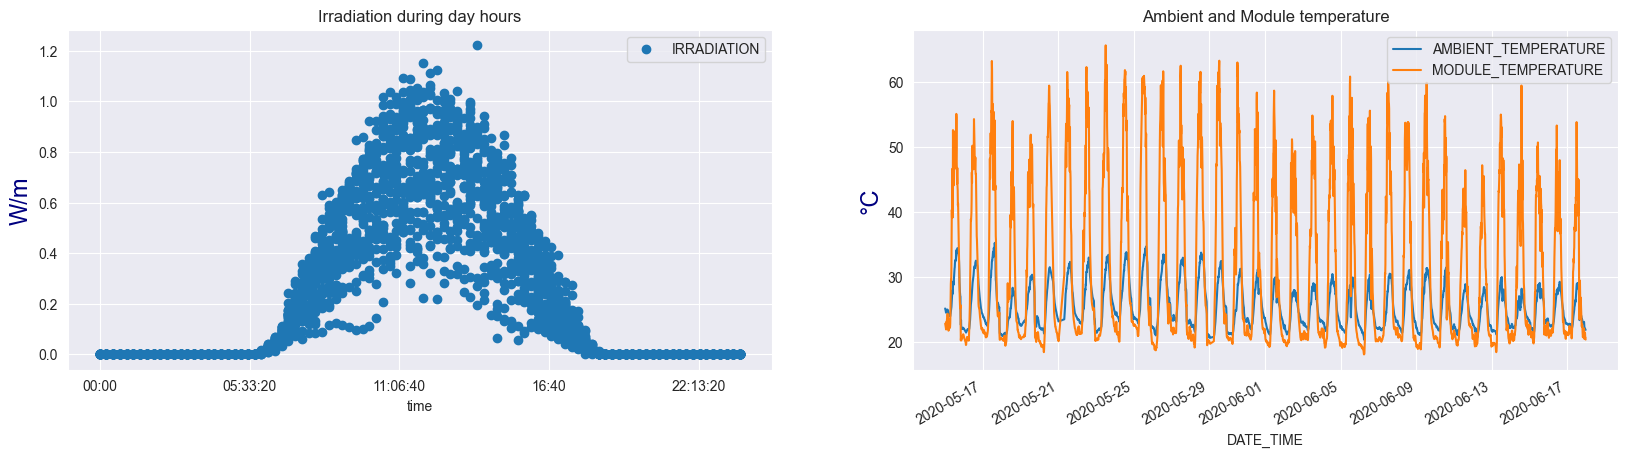

In [16]:
df_sens=sens_1.groupby('DATE_TIME').sum().reset_index()
df_sens['time']=df_sens['DATE_TIME'].dt.time

fig,ax = plt.subplots(ncols=2,nrows=1,dpi=100,figsize=(20,5))
# daily yield plot
df_sens.plot(x='time',y='IRRADIATION',ax=ax[0],style='o')
# AC & DC power plot
df_sens.set_index('DATE_TIME').drop('time',1)[['AMBIENT_TEMPERATURE','MODULE_TEMPERATURE']].plot(ax=ax[1])

ax[0].set_title('Irradiation during day hours',)
ax[1].set_title('Ambient and Module temperature')
ax[0].set_ylabel('W/m',color='navy',fontsize=17)
ax[1].set_ylabel('°C',color='navy',fontsize=17)


plt.show()

# Task 1: Can we identify faulty or suboptimally performing equipment?

Well let's see how all inverters works during day hours, cause we know from the quick eda that something went wrong with dc power generation:
Notice that what matters for us is the DC power generation that then is converted in AC power for domestic use:

## Real DC power converted
#### As we can see below PLANT_1 it's able to convert about only 9-10 % of DC POWER produced by module: Inverters are inefficient!

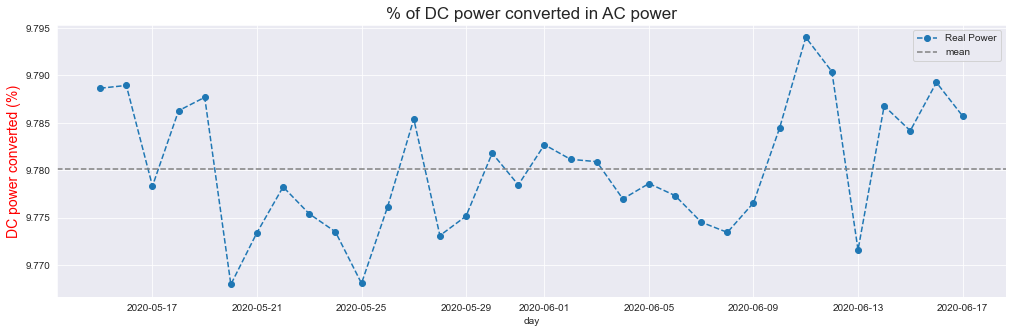

In [17]:
losses=gen_1.copy()
losses['day']=losses['DATE_TIME'].dt.date
losses=losses.groupby('day').sum()
losses['losses']=losses['AC_POWER']/losses['DC_POWER']*100

losses['losses'].plot(style='o--',figsize=(17,5),label='Real Power')

plt.title('% of DC power converted in AC power',size=17)
plt.ylabel('DC power converted (%)',fontsize=14,color='red')
plt.axhline(losses['losses'].mean(),linestyle='--',color='gray',label='mean')
plt.legend()
plt.show()

## DC power generated during day hours

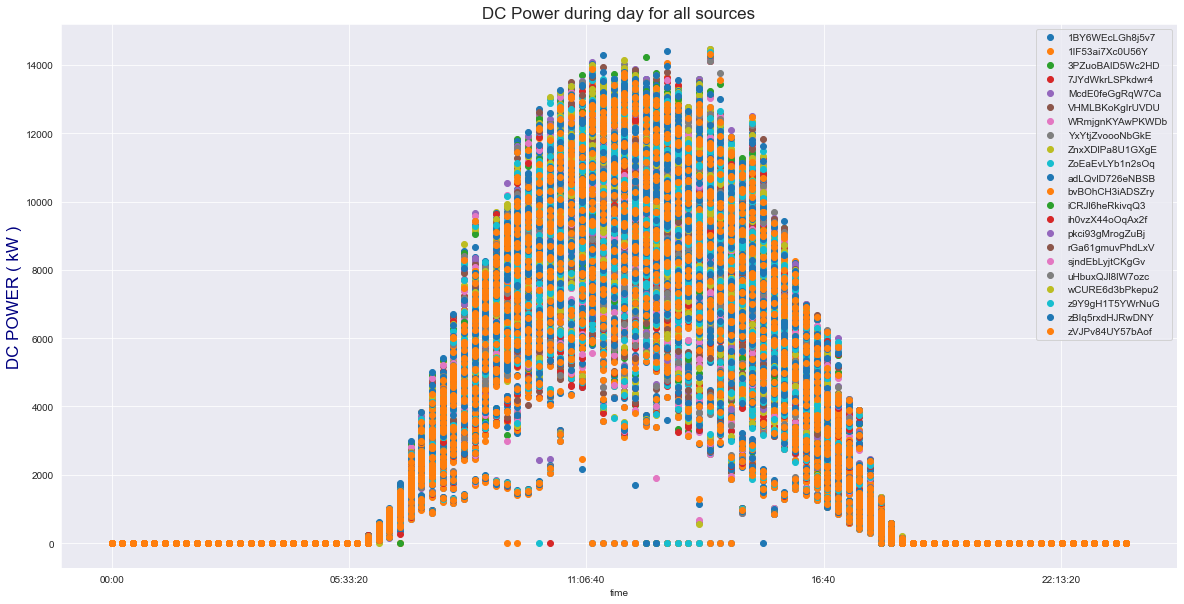

In [18]:
sources=gen_1.copy()
sources['time']=sources['DATE_TIME'].dt.time
sources.set_index('time').groupby('SOURCE_KEY')['DC_POWER'].plot(style='o',legend=True,figsize=(20,10))
plt.title('DC Power during day for all sources',size=17)
plt.ylabel('DC POWER ( kW )',color='navy',fontsize=17)
plt.show()

Well, this look like a strange and cool painting, but we cant'see clearly what is going wrong in our power plant so let's go into deep to see better how different inverters works during day hours.
This take us to the lead question:

## Which inverter is underperforming?

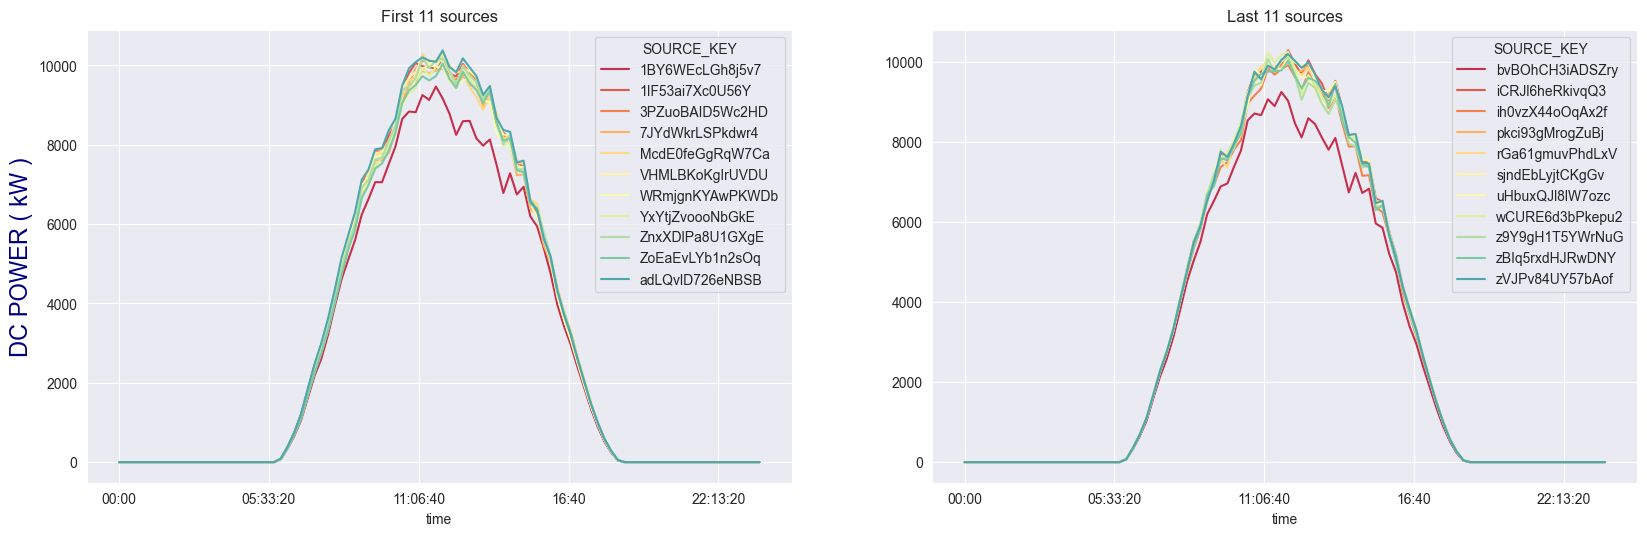

In [19]:
dc_gen=gen_1.copy()
dc_gen['time']=dc_gen['DATE_TIME'].dt.time
dc_gen=dc_gen.groupby(['time','SOURCE_KEY'])['DC_POWER'].mean().unstack()

cmap = sns.color_palette("Spectral", n_colors=12)

fig,ax=plt.subplots(ncols=2,nrows=1,dpi=100,figsize=(20,6))
dc_gen.iloc[:,0:11].plot(ax=ax[0],color=cmap)
dc_gen.iloc[:,11:22].plot(ax=ax[1],color=cmap)

ax[0].set_title('First 11 sources')
ax[0].set_ylabel('DC POWER ( kW )',fontsize=17,color='navy')
ax[1].set_title('Last 11 sources')
plt.show()

#### Here we can see, clearly, that 1BY6WEcLGh8j5v7 & bvBOhCH3iADSZry are underperforming compared to other inverters, maybe these inverters require maintenance or require to be replaced. But before going into deep with underperforming inverters, let's look at which are the common problems for the entire plant,so let's see DC power generation during day hours for all 34 days.

In [20]:
temp1_gen=gen_1.copy()

temp1_gen['time']=temp1_gen['DATE_TIME'].dt.time
temp1_gen['day']=temp1_gen['DATE_TIME'].dt.date


temp1_sens=sens_1.copy()

temp1_sens['time']=temp1_sens['DATE_TIME'].dt.time
temp1_sens['day']=temp1_sens['DATE_TIME'].dt.date

# just for columns
cols=temp1_gen.groupby(['time','day'])['DC_POWER'].mean().unstack()

## DC POWER and DAILY YIELD in PLANT_1

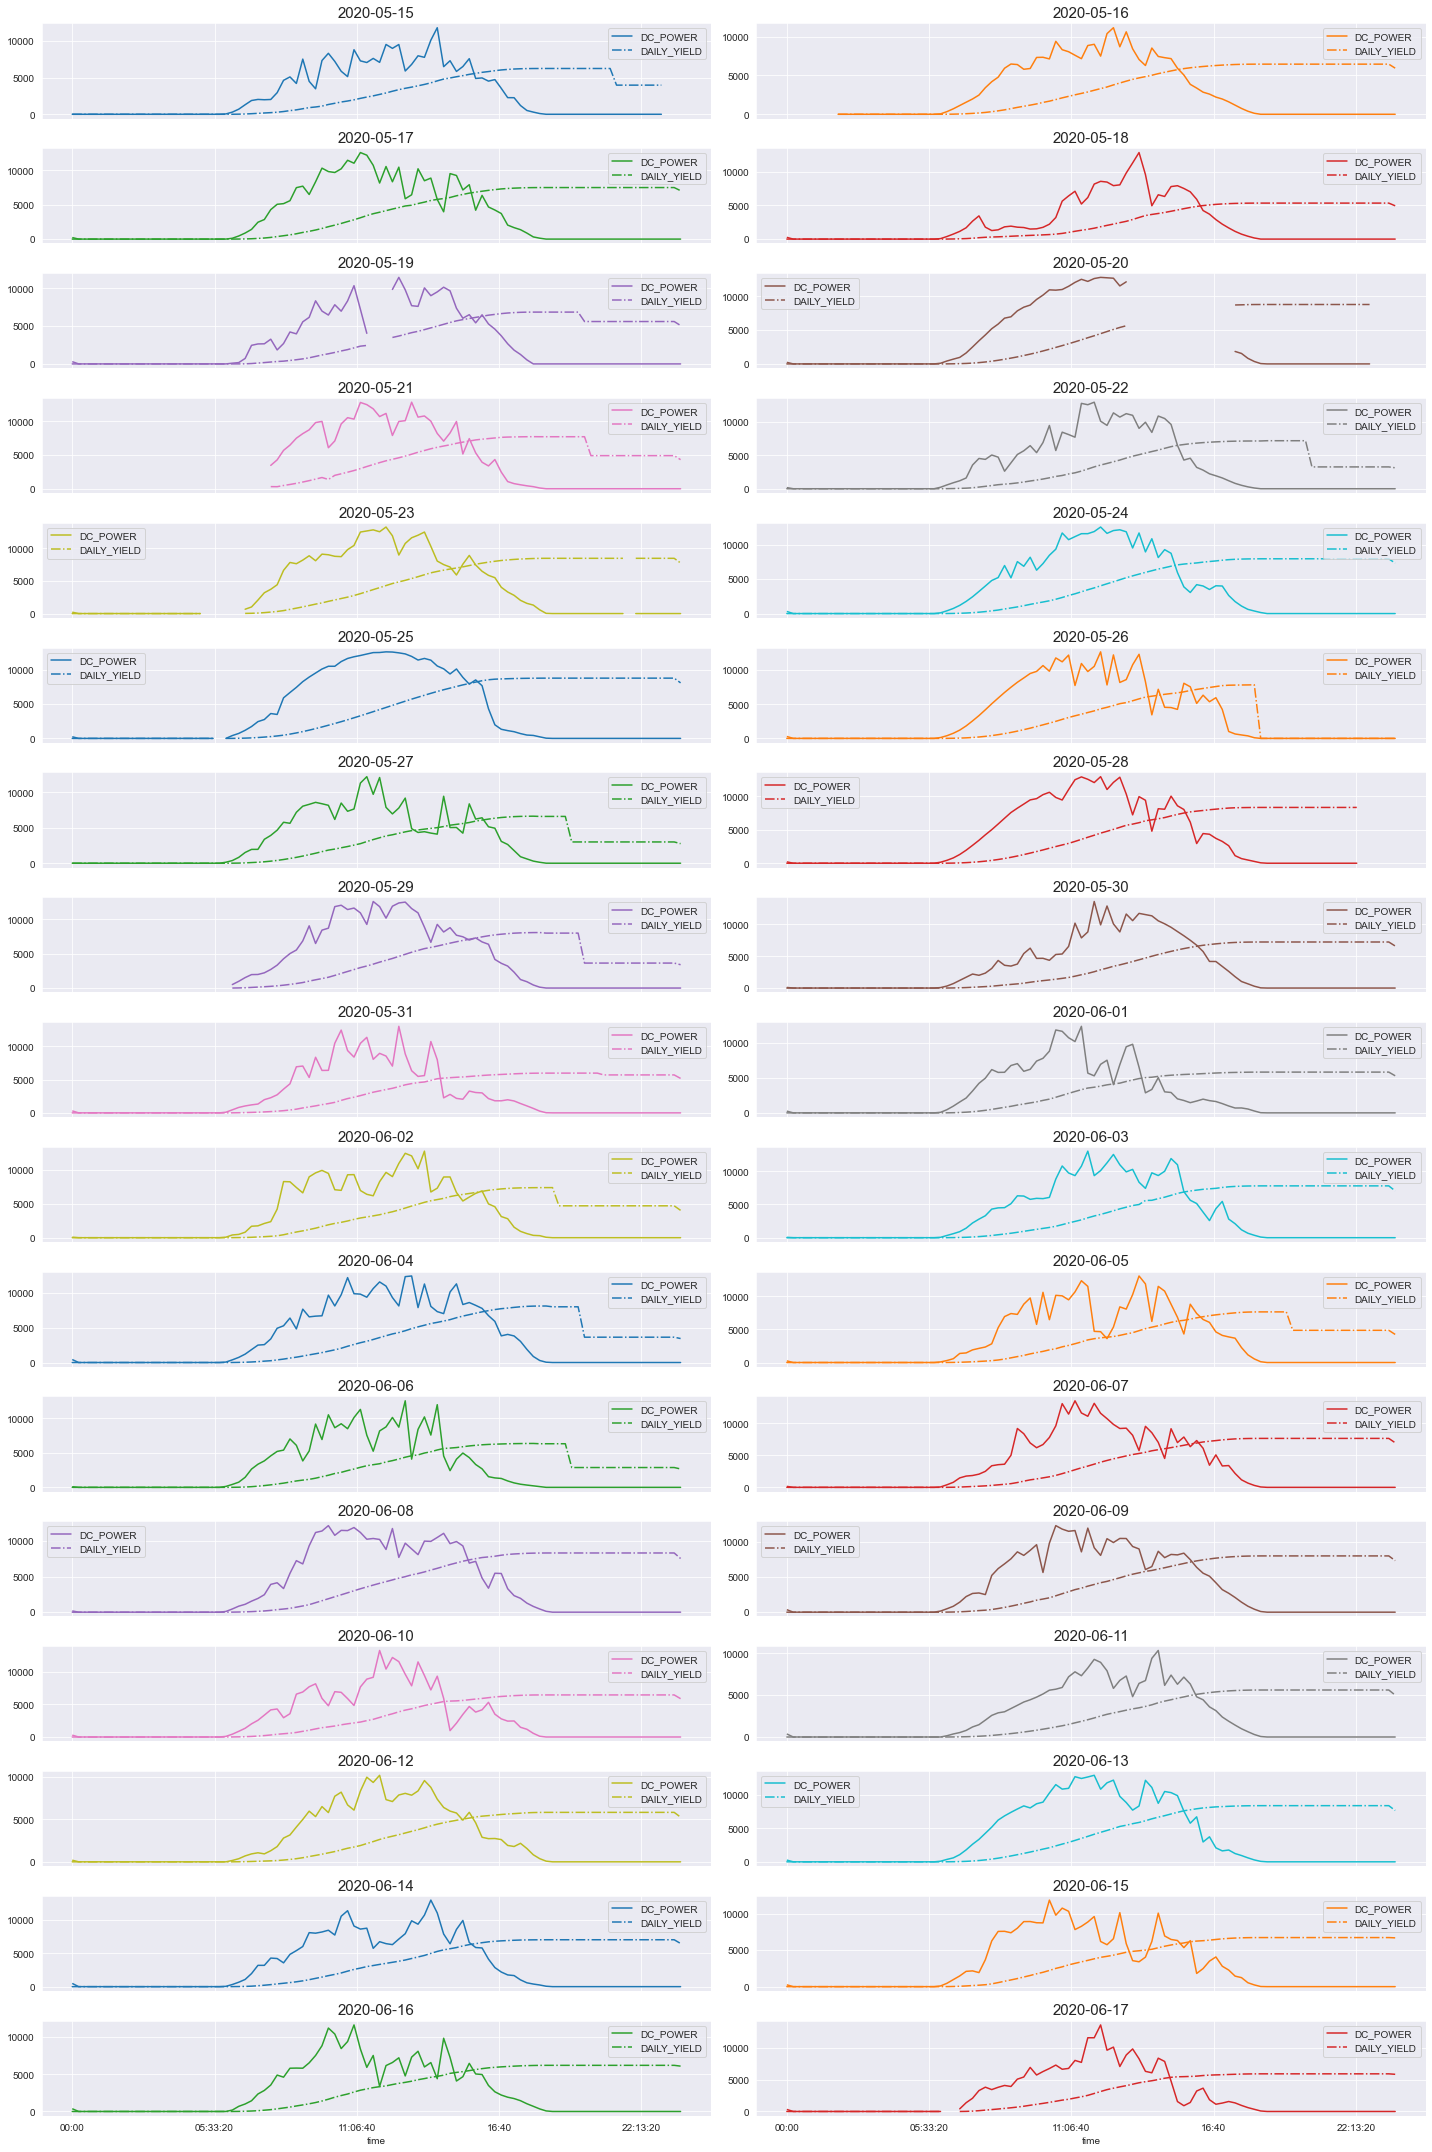

In [21]:
ax =temp1_gen.groupby(['time','day'])['DC_POWER'].mean().unstack().plot(sharex=True,subplots=True,layout=(17,2),figsize=(20,30))
temp1_gen.groupby(['time','day'])['DAILY_YIELD'].mean().unstack().plot(sharex=True,subplots=True,layout=(17,2),figsize=(20,20),style='-.',ax=ax)

i=0
for a in range(len(ax)):
    for b in range(len(ax[a])):
        ax[a,b].set_title(cols.columns[i],size=15)
        ax[a,b].legend(['DC_POWER','DAILY_YIELD'])
        i=i+1

plt.tight_layout()
plt.show()

#### It seems that in some days there have been several problems with the plant, i.e. between 2020-05-19 and 2020-05-21 we can see a period which has null values that are common in daily yield and dc power generation. This may be due to a technical problem of the plant. Let's give a further look to ambient and module temperature:

## Module temperature and Ambient Temperature on PLANT_1

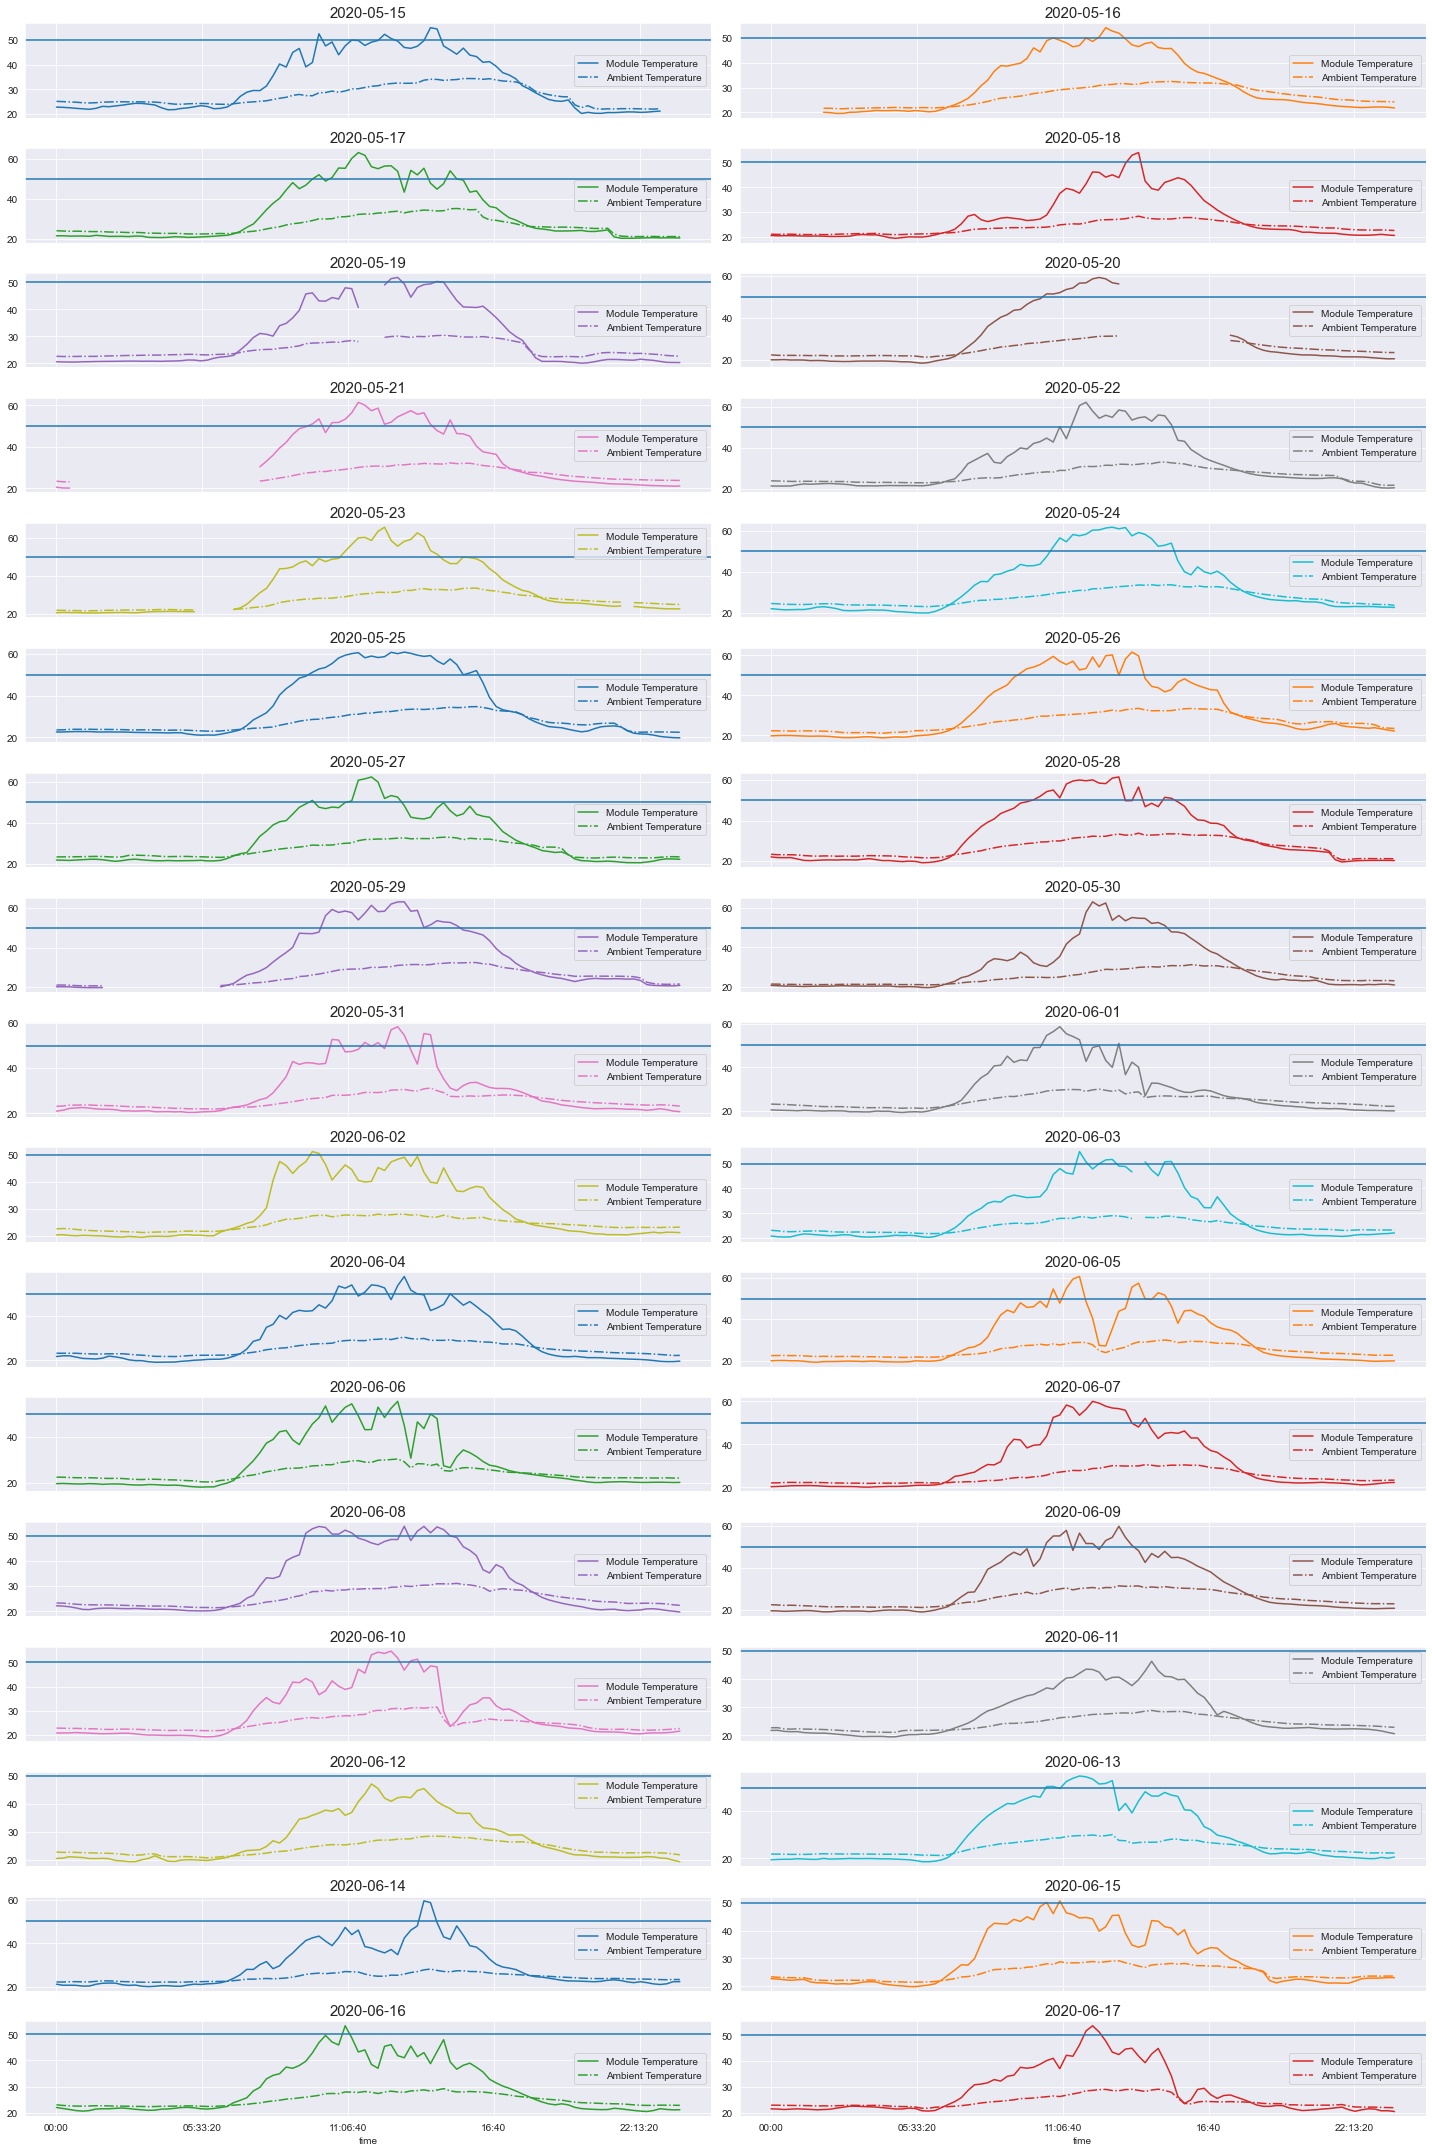

In [22]:
ax= temp1_sens.groupby(['time','day'])['MODULE_TEMPERATURE'].mean().unstack().plot(subplots=True,layout=(17,2),figsize=(20,30))
temp1_sens.groupby(['time','day'])['AMBIENT_TEMPERATURE'].mean().unstack().plot(subplots=True,layout=(17,2),figsize=(20,40),style='-.',ax=ax)

i=0
for a in range(len(ax)):
    for b in range(len(ax[a])):
        ax[a,b].axhline(50)
        ax[a,b].set_title(cols.columns[i],size=15)
        ax[a,b].legend(['Module Temperature','Ambient Temperature'])
        i=i+1

plt.tight_layout()
plt.show()

Well, it seems that in that period the plant doesn't work at all. So we must suppose that there was a technical problem in the plant.
Notice that a decrease in ambient temperature,just for a couple of degrees, influence quite a lot module temperature.

**P.S. I've drawn a line to see when module temperature goes over 50 degrees, this because a module overload may be the cause of a non-performing inverter.**

## Inverter bvBOhCH3iADSZry in action

#### As we can see between the 7th and 14th of June the dc power produced by the inverter goes quickly to 0 exactly during maximum sunlight hours, between 11 am and 16 pm. This can only be due to a fault in the inverter, so maybe these inverters requires to be fixed or replaced.

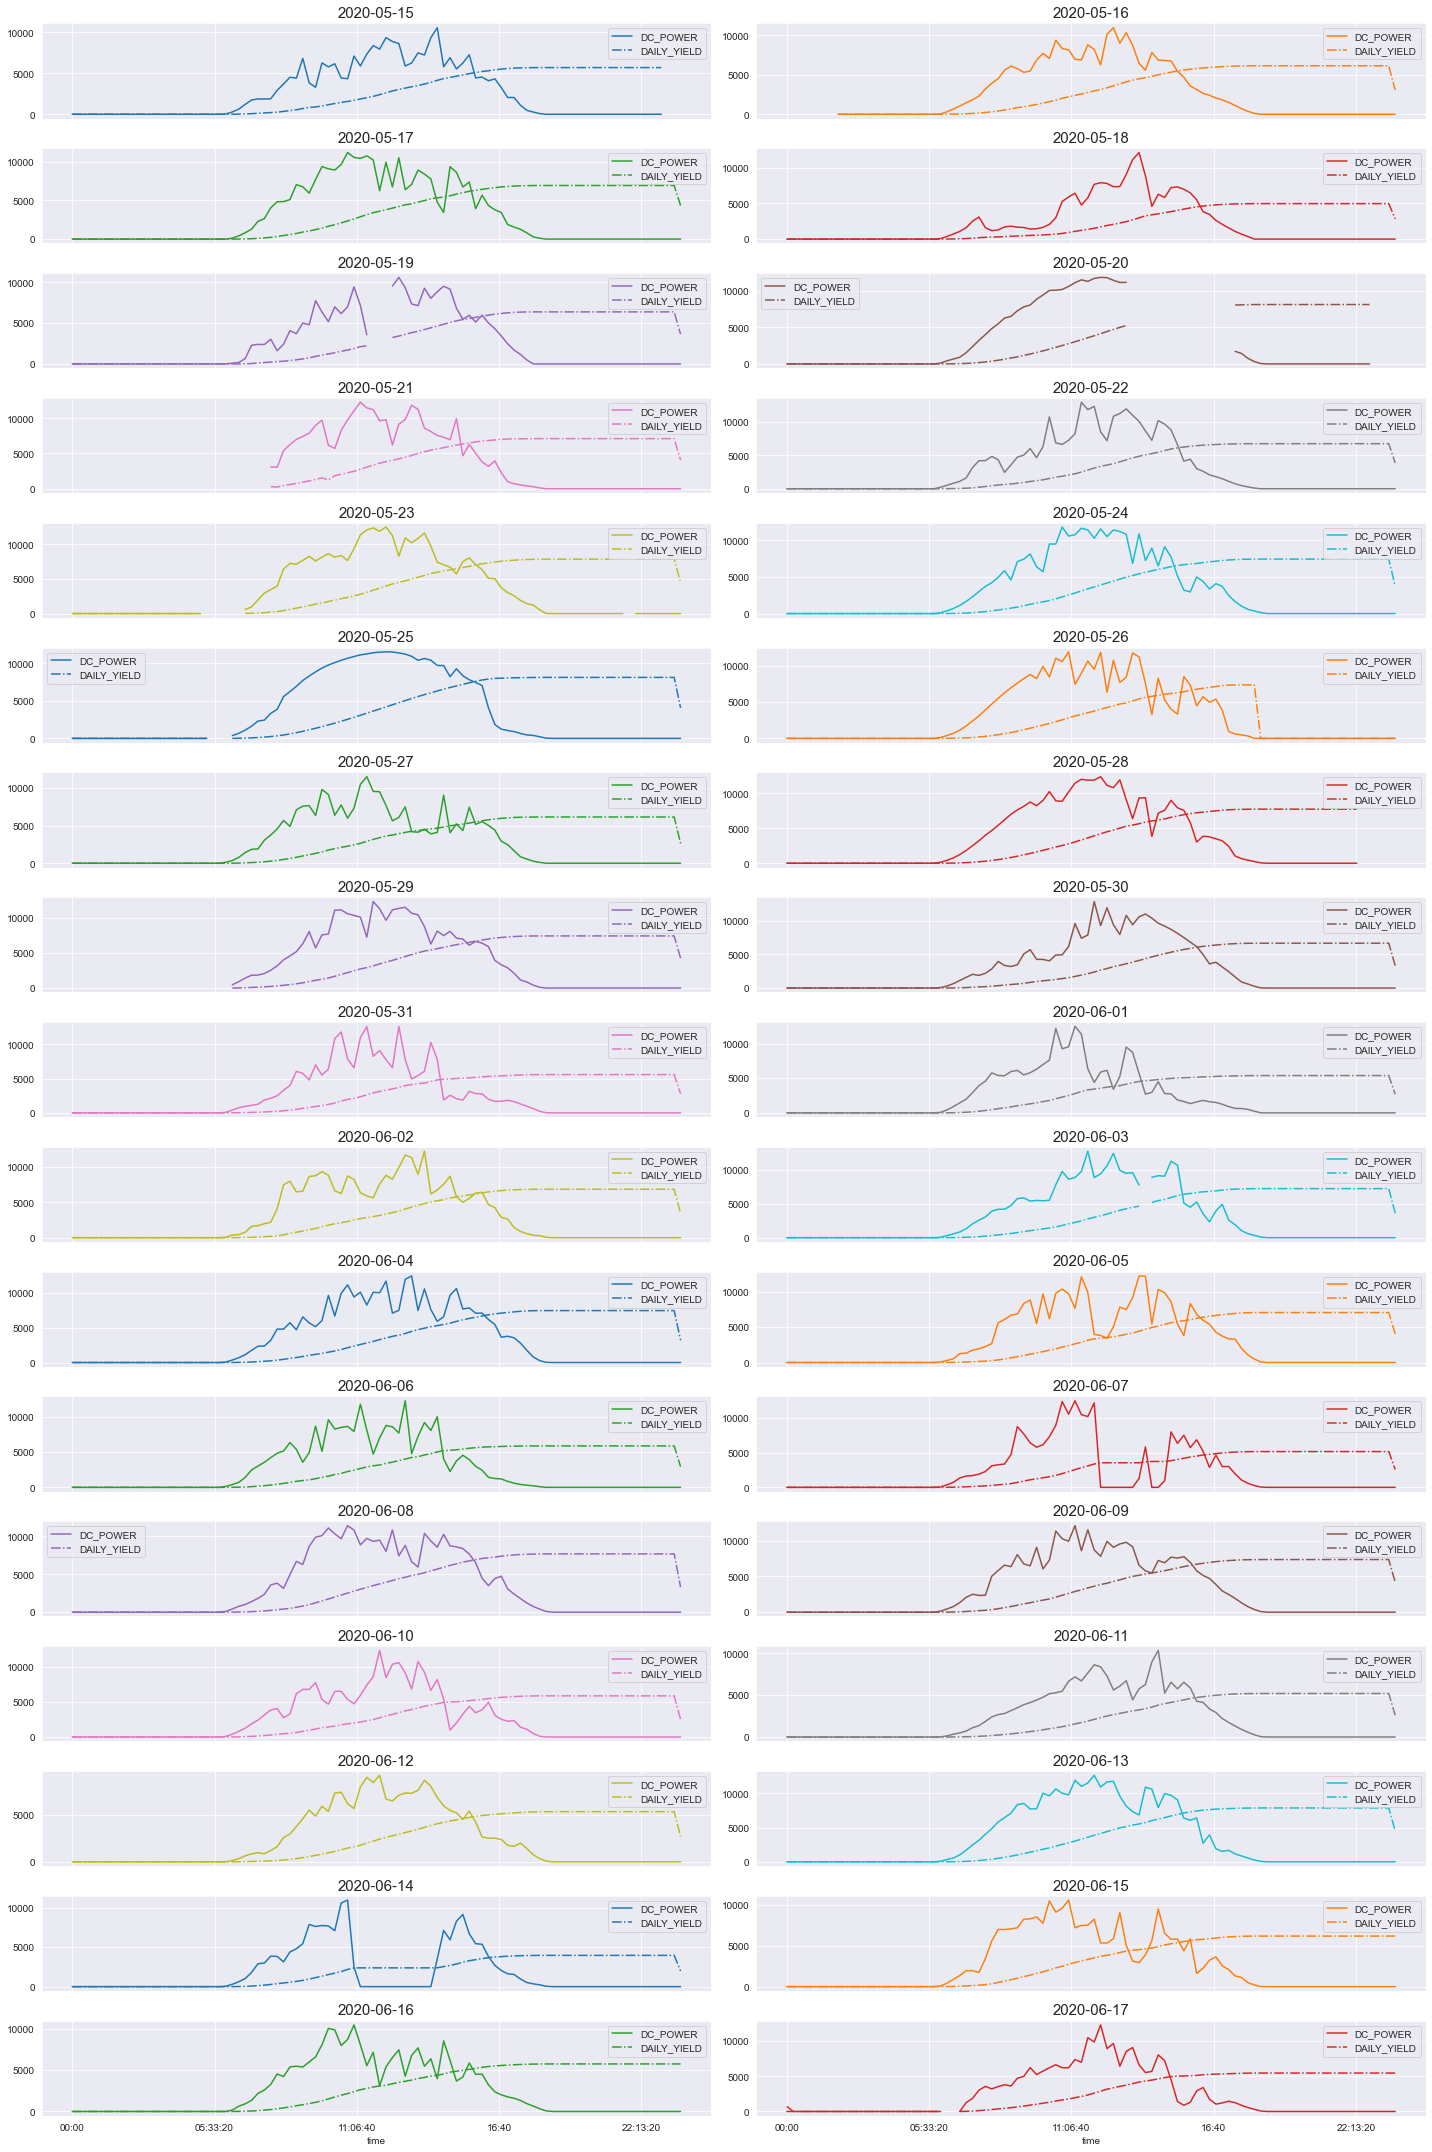

In [23]:
worst_source=gen_1[gen_1['SOURCE_KEY']=='bvBOhCH3iADSZry']
worst_source['time']=worst_source['DATE_TIME'].dt.time
worst_source['day']=worst_source['DATE_TIME'].dt.date

ax=worst_source.groupby(['time','day'])['DC_POWER'].mean().unstack().plot(sharex=True,subplots=True,layout=(17,2),figsize=(20,30))
worst_source.groupby(['time','day'])['DAILY_YIELD'].mean().unstack().plot(sharex=True,subplots=True,layout=(17,2),figsize=(20,30),ax=ax,style='-.')

i=0
for a in range(len(ax)):
    for b in range(len(ax[a])):
        ax[a,b].set_title(cols.columns[i],size=15)
        ax[a,b].legend(['DC_POWER','DAILY_YIELD'])
        i=i+1

plt.tight_layout()
plt.show()

# Task 2: Forecast
## Can we predict the power generation for next couple of days? 

We're going to predict exactly the next two days of yield generated by plant_1, please note that we can have similar results predicting dc power generation rather then daily yield generated, but I think that for this purpose daily yield generated power is a good evidence of power prediction.

We will tune, with auto_arima function, a SEASONAL ARIMA(p,d,q) + (P,D,Q,m) model,on the last 4 days(384 observations) to see if our model can capture the last generation trend. 

In [24]:
from pandas.tseries.offsets import DateOffset
! pip install pmdarima
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import adfuller

#### Our data:

In [25]:
pred_gen=gen_1.copy()
pred_gen=pred_gen.groupby('DATE_TIME').sum()
pred_gen=pred_gen['DAILY_YIELD'][-288:].reset_index()
pred_gen.set_index('DATE_TIME',inplace=True)
pred_gen.head()

,DAILY_YIELD
DATE_TIME,
2020-06-14 23:30:00,155054.000000
2020-06-14 23:45:00,142682.392857
2020-06-15 00:00:00,5480.000000
2020-06-15 00:15:00,0.000000
2020-06-15 00:30:00,0.000000


## Step 1: Testing for Stationarity

We can use the Augmented [Dickey-Fuller](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test) [unit root test](https://en.wikipedia.org/wiki/Unit_root_test).

In statistics and econometrics, an augmented Dickey–Fuller test (ADF) tests the null hypothesis that a unit root is present in a time series sample. The alternative hypothesis is different depending on which version of the test is used, but is usually stationarity or trend-stationarity.

Basically, we are trying whether to accept the Null Hypothesis **H0** (that the time series has a unit root, indicating it is non-stationary) or reject **H0** and go with the Alternative Hypothesis (that the time series has no unit root and is stationary).

We end up deciding this based on the p-value return.

* A small p-value (typically ≤ 0.05) indicates strong evidence against the null hypothesis, so you reject the null hypothesis.

* A large p-value (> 0.05) indicates weak evidence against the null hypothesis, so you fail to reject the null hypothesis.

Let's run the Augmented Dickey-Fuller test on our data:

In [26]:
result = adfuller(pred_gen['DAILY_YIELD'])
print('Augmented Dickey-Fuller Test:')
labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']

for value,label in zip(result,labels):
    print(label+' : '+str(value) )
    
if result[1] <= 0.05:
    print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
else:
    print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

Augmented Dickey-Fuller Test:
ADF Test Statistic : -2.2899376474793622
p-value : 0.17523382074929617
#Lags Used : 1
Number of Observations Used : 286
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


From the above, we can conclude that the data is non-stationary. Hence, we would need to use the “Integrated (I)” concept, denoted by value ‘d’ in time series to make the data stationary while building the Auto ARIMA model.

## Step 2: Split into train and test datasets to build the model on the training dataset and forecast using the test dataset.

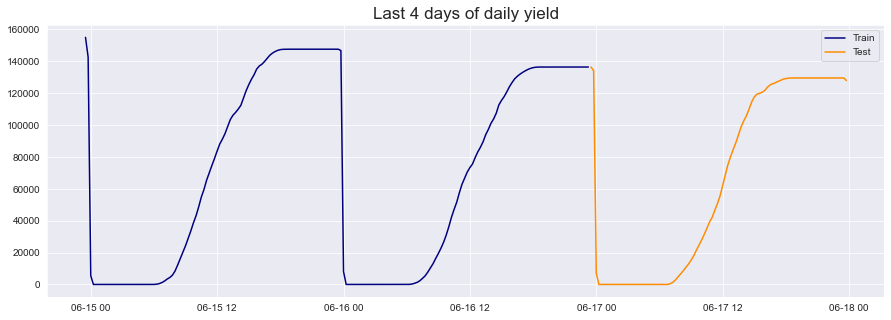

In [27]:
train=pred_gen[:192]
test=pred_gen[-96:]
plt.figure(figsize=(15,5))
plt.plot(train,label='Train',color='navy')
plt.plot(test,label='Test',color='darkorange')
plt.title('Last 4 days of daily yield',fontsize=17)
plt.legend()
plt.show()

## Step 3: Tune with the auto_arima function:

The auto_arima function fits the best ARIMA model to an univariate time series according to a provided information criterion (either AIC, AICc, BIC or HQIC). The function performs a search (either stepwise or parallelized) over possible model & seasonal orders within the constraints provided, and selects the parameters that minimize the given metric.

Seasonal ARIMA models have three parameters that heavily resemble our p, d and q parameters:

`P` is  The order of the seasonal component for the auto-regressive (AR) model.

`D` is The integration order of the seasonal process.

`Q` is The order of the seasonal component of the moving average (MA) model.
P and Q and be estimated similarly to p and q via auto_arima, and D can be estimated via a Canova-Hansen test, however m generally requires subject matter knowledge of the data.

Since we know that our observations are recorded at 15 minute intervals, (so for each day we have 96 observations) we can choose `m` parameter equal to 96 to capture daily trend.
To speed up the parameters search, I fixed a max order of 1 for P,D,Q paramaters in the seasonal component. 

In [28]:
arima_model = auto_arima(train,
                         start_p=0,d=1,start_q=0,
                         max_p=4,max_d=4,max_q=4,
                         start_P=0,D=1,start_Q=0,
                         max_P=1,max_D=1,max_Q=1,m=96,
                         seasonal=True,
                         error_action='warn',trace=True,
                         supress_warning=True,stepwise=True,
                         random_state=20,n_fits=1)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[96]             : AIC=1645.555, Time=2.83 sec
 ARIMA(1,1,0)(1,1,0)[96]             : AIC=1539.889, Time=40.74 sec
 ARIMA(0,1,1)(0,1,1)[96]             : AIC=1541.502, Time=71.63 sec
 ARIMA(1,1,0)(0,1,0)[96]             : AIC=1539.528, Time=7.98 sec
 ARIMA(1,1,0)(0,1,1)[96]             : AIC=1539.889, Time=28.67 sec
 ARIMA(1,1,0)(1,1,1)[96]             : AIC=inf, Time=62.60 sec
 ARIMA(2,1,0)(0,1,0)[96]             : AIC=1538.237, Time=13.65 sec
 ARIMA(2,1,0)(1,1,0)[96]             : AIC=1539.552, Time=48.81 sec
 ARIMA(2,1,0)(0,1,1)[96]             : AIC=1539.555, Time=46.26 sec
 ARIMA(2,1,0)(1,1,1)[96]             : AIC=inf, Time=64.94 sec
 ARIMA(3,1,0)(0,1,0)[96]             : AIC=1530.967, Time=16.08 sec
 ARIMA(3,1,0)(1,1,0)[96]             : AIC=1528.008, Time=58.08 sec
 ARIMA(3,1,0)(1,1,1)[96]             : AIC=inf, Time=96.76 sec
 ARIMA(3,1,0)(0,1,1)[96]             : AIC=1527.753, Time=58.19 sec
 ARIMA(4,1,0)(0,1,1)[9

## Step 4: Use the trained model which was built earlier to forecast daily yields

We use the trained model to forecast the last 96 observations of the test data, 17th June daily yield,  and then we will forecast daily yield for 18th and 19th June.

In [29]:
future_dates = [test.index[-1] + DateOffset(minutes=x) for x in range(0,2910,15) ]

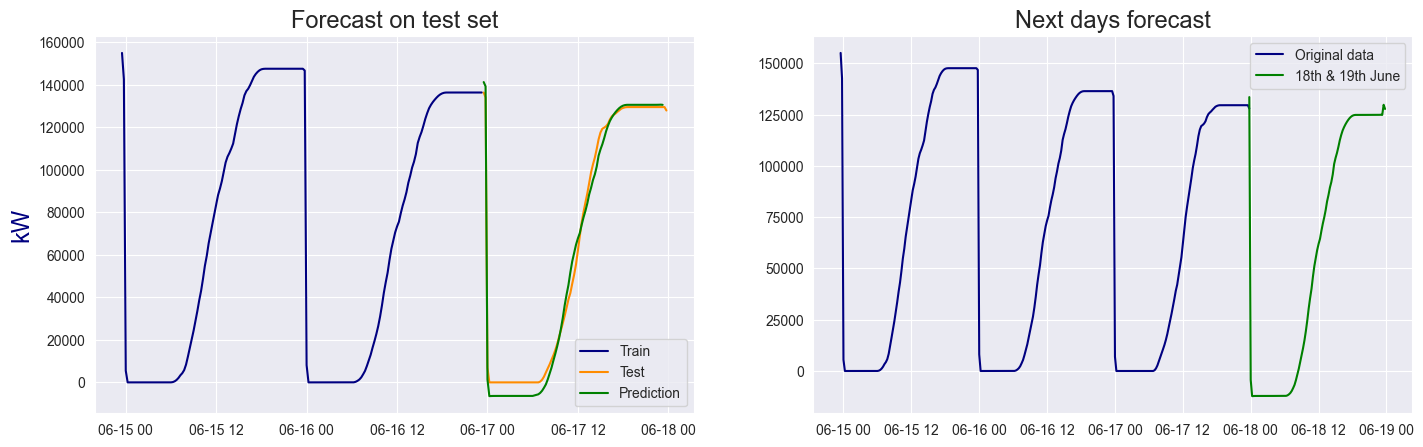

In [30]:
prediction=pd.DataFrame(arima_model.predict(n_periods=96),index=test.index)
prediction.columns=['predicted_yield']

fig,ax= plt.subplots(ncols=2,nrows=1,dpi=100,figsize=(17,5))
ax[0].plot(train,label='Train',color='navy')
ax[0].plot(test,label='Test',color='darkorange')
ax[0].plot(prediction,label='Prediction',color='green')
ax[0].legend()
ax[0].set_title('Forecast on test set',size=17)
ax[0].set_ylabel('kW',color='navy',fontsize=17)


f_prediction=pd.DataFrame(arima_model.predict(n_periods=194),index=future_dates)
f_prediction.columns=['predicted_yield']
ax[1].plot(pred_gen,label='Original data',color='navy')
ax[1].plot(f_prediction,label='18th & 19th June',color='green')
ax[1].legend()
ax[1].set_title('Next days forecast',size=17)
plt.show()

## Model summary:

In [31]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  192
Model:             SARIMAX(4, 1, 0)x(0, 1, [1], 96)   Log Likelihood                -757.647
Date:                              Tue, 07 Mar 2023   AIC                           1527.294
Time:                                      02:35:35   BIC                           1542.617
Sample:                                  06-14-2020   HQIC                          1533.486
                                       - 06-16-2020                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2318      0.025     -9.315      0.000      -0.281      -0.183
ar.L2          0.0985      0.058      1.699      0.089      -0.015       0.212
ar.L3          0.0988      0.041      2.434      0.015       0.019       0.178
ar.L4          0.0265      0.068      0.389      0.697      -0.107       0.160
ma.S.L96      -0.1111      0.053     -2.100      0.036      -0.215      -0.007
sigma2      5.751e+05    6.5e+04      8.852      0.000    4.48e+05    7.02e+05
===================================================================================
Ljung-Box (L1) (Q):                  17.39   Jarque-Bera (JB):                27.18
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               5.49   Skew:                             0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# An Alternative way: Prophet

Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

One of the advantages of is that can be much more faster then ARIMA procedure of forecasting,especially when you're dealing with a long time series, such as our case, but we must take into account that this metodology in under development and not fully stable.

In [32]:
from fbprophet import Prophet
pred_gen2=gen_1.copy()
pred_gen2=pred_gen2.groupby('DATE_TIME')['DAILY_YIELD'].sum().reset_index()
pred_gen2.rename(columns={'DATE_TIME':'ds','DAILY_YIELD':'y'},inplace=True)
pred_gen2.plot(x='ds',y='y',figsize=(17,5))
plt.legend('')
plt.title('DAILY_YIELD',size=17)
plt.show()

ModuleNotFoundError: No module named 'fbprophet'

In [35]:
!pip install --upgrade plotly

     --------------------------------------- 15.2/15.2 MB 11.1 MB/s eta 0:00:00
  Attempting uninstall: plotly
    Found existing installation: plotly 5.5.0
    Uninstalling plotly-5.5.0:
      Successfully uninstalled plotly-5.5.0


## Step 1: Fit Prophet to our data

In [ ]:
m = Prophet()
m.fit(pred_gen2)

In [ ]:
future = [pred_gen2['ds'].iloc[-1:] + DateOffset(minutes=x) for x in range(0,2910,15) ]
time1=pd.DataFrame(future).reset_index().drop('index',1)
time1.rename(columns={3157:'ds'},inplace=True)

In [ ]:
timeline=pd.DataFrame(pred_gen2['ds'])
fut=timeline.append(time1,ignore_index=True)
fut.tail()

NameError: name 'pd' is not defined

In [ ]:
forecast = m.predict(fut)

NameError: name 'm' is not defined

In [ ]:
m.plot(forecast,figsize=(15,7))
plt.title('ok')
plt.legend(labels=['Original data','Prophet Forecast'])
plt.title('Prophet Forecast')
plt.show()

NameError: name 'm' is not defined

# Metrics score: SARIMAX vs PROPHET

To understand which model performs better:

In [ ]:
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
test2=pd.DataFrame(test.index)
test2.rename(columns={'DATE_TIME':'ds'},inplace=True)
test_prophet=m.predict(test2)

NameError: name 'pd' is not defined

In [ ]:
print('SARIMAX R2 Score: %f' % (r2_score(prediction['predicted_yield'],test['DAILY_YIELD'])))
print('Prophet R2 Score: %f' % (r2_score(test['DAILY_YIELD'],test_prophet['yhat'])))
print('-'*15)
print('SARIMAX MAE Score: %f' % (mean_absolute_error(prediction['predicted_yield'],test['DAILY_YIELD'])))
print('Prophet MAE Score: %f' % (mean_absolute_error(test['DAILY_YIELD'],test_prophet['yhat'])))
print('-'*15)
print('SARIMAX RMSE Score: %f' % (mean_squared_error(prediction['predicted_yield'],test['DAILY_YIELD'],squared=False)))
print('Prophet RMSE Score: %f' % (mean_squared_error(test['DAILY_YIELD'],test_prophet['yhat'],squared=False)))

NameError: name 'prediction' is not defined

 # Conclusions
## Task 1:
#### For the first main question we have seen potentially subperforming inverters, we can also exclude that their blackouts may be due to higher temperature, so they maybe have only to be replaced or fixed.
 
## Task 2:
### We have seen 2 different ways to forecast an univariate time series:
* PROPHET is much more handy to handle and clearly much more faster then SARIMAX.
* Tune arima parameters trought auto_arima function requires knowledge about the data and about how this model works,even if our forecast seems to be good for this purpose it's always advisable to go with statistical techniques and implement the basic ARIMA model to understand the insights behind the p,d, and q values to better understand and quantify our forecast.


#### As we can see above, metrics talks, and say that on the same test set PROPHET have a quite large error of forecast,so we will rely on SARIMAX model, to show to our chief which steps do for future.
 
# That's all for today. Thanks for reading and please upvote!